In [1]:
import pandas as pd
import numpy as np
from pandas.core.common import flatten
from plotnine import *
from array import *
import scipy.stats as stats
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import os
import tarfile
import urllib.request
import pandas as pd

In [2]:
# definir las rutas y caminos donde se encuentran los datos------
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# path que se va a crear en nuestro sistema----------------------
HOUSING_PATH = os.path.join("datasets", "housing")
# lugar de descarga del dataset----------------------------------
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
# definir una funcion que obtenga los datos y los descargue-----
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [4]:
# definir una funcion que cargue el csv en un dataframe----------
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

## En este ejercicio profundizarás en los modelos de regresión lineal general. Carga el dataset California housing, y realiza:

## a) Un modelo de regresión lineal general de la mediana de los valores de las casas (variable respuesta Y ) con todas las variables numéricas del dataset.

Como se va a realizar el ajuste de un modelo de regresión lineal general de la variable
respuesta median_house_value con el resto de variables del dataset como variables
predictoras es necesario separar en la respuesta Y , y el resto de variables del dataset.

In [5]:
respuesta = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)

Recordando la información sobre las variables que conforman el dataset nos damos
cuenta que es necesario salvar un obstáculo para poder ajustar el modelo de regresión
lineal: la variable total_bedrooms tiene menos valores que el resto de variables, esto
quiere decir que tiene datos faltantes.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


Es necesario hacer algo con los datos faltantes que se encuentran en la variable total
bedrooms. En el tema anterior se eliminaron esas observaciones, pero para no perder
la información que sí proporcionan el resto de variables en este caso se va a imputar el
valor faltante, por el valor de la mediana de la variable. Para lograr la imputación se
va a hacer uso del objeto SimpleImputer() en el cual definiremos como estrategia de
imputación la mediana.

Este imputador va a tratar de imputar todas las variables del dataset. Si se prueba a
imputar la base de datos original obtendremos un error relacionado con que no se
puede imputar la mediana en una variable categórica. Así pues, quitaremos la variable
categórica ocean_proximity y se imputará el valor de los datos faltantes.

Para quitar una variable empleamos el método .drop() donde en el argumento axis
definimos que se refiere a columnas utilizando axis=1. Hay que tener en cuenta que al
realizar la imputación mediante el método .transform() se obtiene un array y es nece-
sario volver a definirlo como un dataframe con la función pd.DataFrame(). Por último,
se vuelve a aplicar el método .info() sobre el dataframe imputado para comprobar que
ya no existen datos faltantes.

In [8]:
# imputar NAs----------------------------------------------------
from sklearn.impute import SimpleImputer
imputador = SimpleImputer(strategy="median")
# imputador.fit(housing) # da error
# se quita la variable categorica--------------------------------
housing_num = housing.drop("ocean_proximity", axis=1)
# se calcula la imputacion---------------------------------------
imputador.fit(housing_num)
# los valores de las mediana
## SimpleImputer(strategy='median')
print(imputador.statistics_)
# se aplica la imputacion----------------------------------------
housing_num_i = imputador.transform(housing_num)
# volver a data frame--------------------------------------------
housing_i = pd.DataFrame(housing_num_i,
columns=housing_num.columns, index=housing.index)
# Comprobar df imputado------------------------------------------
print(housing_i.info())

[-118.49     34.26     29.     2127.      435.     1166.      409.
    3.5348]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None


Una vez que se ha comprobado que ya no existen valores faltantes se procede a preprocesar las variables predictoras. En muchos de los métodos de aprendizaje automático
es necesario que el rango de las variables predictoras sea similar (la variable respuesta
no suele hacer falta escalarla). Para ello existen varias estrategias, tal y como se ha
visto en el último apartado del tema.

En este ejercicio se va a optar por estandarizar las variables predictoras. Esta estandarización se debe realizar después de imputar. Para automatizar estos procesos para
futuros problemas se puede definir la clase pipeline de Scikit-Learn, la cual nos permite
realizar todas estas operaciones en el orden correcto. En este caso, se crea un Pipeline
con 2 pasos: imputar y estandarizar, que aplicaremos sobre las variables numéricas del
dataset.

In [14]:
# importar el "estandarizador"-----------------------------------
from sklearn.preprocessing import StandardScaler
# importar la clase pipeline"------------------------------------
from sklearn.pipeline import Pipeline
# definir el pipeline--------------------------------------------
num_pipeline = Pipeline([
("imputador", SimpleImputer(strategy="median")),
("std_scaler", StandardScaler()),
])
# aplicar el pipeline--------------------------------------------
housing_num_tr = num_pipeline.fit_transform(housing_num)
# importar clase-------------------------------------------------
from sklearn.linear_model import LinearRegression
# ajustar el modelo----------------------------------------------
lm1 = LinearRegression()
lm1.fit(housing_num_tr, respuesta)
# obtener coeficientes del modelo--------------------------------
# intercepto
print(lm1.intercept_)
# coeficientes de regresion
print(lm1.coef_)

206855.8169089139
[-85369.22518    -90723.40175504  14403.20315262 -14443.94445799
  34037.42560482 -45153.79498679  30319.8204304   75520.30834439]


Se obtiene en lm1.intercept_ la interceptación del modelo y en lm1.coef_ los betas del
modelo.

## b) La librería Scikit-Learn no proporciona los p. valores o intervalos de confianza de la estimación de los coeficientes de regresión del modelo. Obten estos valores mediante la librería statsmodels. ¿Qué variables son estadísticamente significativas en el modelo de regresión general? Además, representa los valores predichos del modelo de regresión lineal general frente a los reales. ¿Ajusta bien el modelo?

Para ajustar el modelo de regresión lineal mediante statmodels se va a aprovechar todo
el preprocesado empleado en el apartado a). Se importa la librería statsmodels.api y la
clase stats de la librería scipy. Se define la matriz X como el conjunto de valores de
housing_prepared y como y la variable respuesta. Es necesario, además, definir explicitamente que el modelo tiene interceptación mediante la función sm.add_constant() a
la matriz X. El ajuste por minimos cuadrados se construye con la función sm.OLS(). Por
último, podemos representar el sumario de la regresión con la función est2.summary().

In [13]:
# cargar funciones-----------------------------------------------
import statsmodels.api as sm
from scipy import stats
# definir matriz de disenyo y variable respuesta-----------------
X = housing_num_tr
y = respuesta
# anyadir intercepto---------------------------------------------
X2 = sm.add_constant(X)
# ajustar el modelo----------------------------------------------
est = sm.OLS(y, X2)
# ver ajuste-----------------------------------------------------
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     4498.
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:14:40   Log-Likelihood:            -2.5945e+05
No. Observations:               20640   AIC:                         5.189e+05
Df Residuals:                   20631   BIC:                         5.190e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.069e+05    484.967    426.536      0.0

Se observa que todas las variables son estadísticamente significativas ya que el p.valor
obtenido es menor de 0.05 para todas las variables. Además de por el p. valor, se
puede comprobar la significatividad observando el intervalo de confianza al nivel 1 − α
[0.025 − 0.975] donde ninguna variable (quitando del mismo nivel donde el p. valor
era mayor que 0.05) contiene al 0.
Se puede observar que el coeficiente de determinación del modelo es igual a 0.636,
y que el coeficiente de determinación ajustado es 0.635. Que la diferencia entre uno
y otro sea tan pequeña es debido a que el número de observaciones es mucho más
grande que el número de variables del modelo.
Aparte del coeficiente de determinación y de la varianza, se puede realizar un gráfico
donde se comparan los valores reales de la muestra frente a los valores del ajuste (ver
Figura 3. Cuanto más se aproximen los puntos del gráfico de dispersión a la bisectriz
del primer cuadrante, mejor será el ajuste del modelo. Aunque este método es útil
gráficamente, para decidir si un modelo ajusta bien o no es preferible basarse en los
p.valores y en el coeficiente de determinación obtenido.

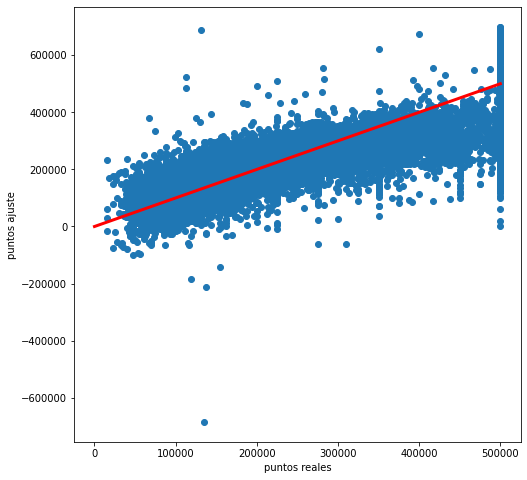

In [15]:
# pintar reales vs predichos
fig = plt.figure(figsize=(8, 8))
y_pred = lm1.predict(housing_num_tr)
plt.scatter(y, y_pred)
plt.xlabel("puntos reales")
plt.ylabel("puntos ajuste")
plt.plot([0, max(y)], [0, max(y)], color = 'red', linewidth = 3)
plt.show()

En términos generales el modelo ajusta bien, concentrándose la mayoría de las predic-
ciones alrededor de la bisectriz del primer cuadrante, aunque existen algunas predic-
ciones que arrojan valores negativos, por lo que es necesario trabajar en mejorar el
modelo.

## c) ¿Cuál sería la predicción de un barrio donde todas sus variables numéricas estuvieran en el valor de la mediana y su variable categórica tuviera el valor de la moda?

Para obtener el valor de la predicción de un barrio donde todas las variables nu-
méricas tienen el valor de la mediana, lo primero es obtener los valores de esa
observación y después emplear el método .predict() de dicha observación. Las
medianas se obtienen de aplicar la función median() al array que contiene a las
variables numéricas. Es interesante recordar que las medianas es necesario extraer-
las de las variables numéricas una vez han pasado por el pipeline() del tratamiento
numérico para introducirlas en la predicción con sus valores escalados.

In [16]:
# obtener observacion medianas
medianas = np.median(housing_num_tr, axis=0)
print(medianas)

[ 0.53891366 -0.6422871   0.02864572 -0.23321042 -0.24283094 -0.22913175
 -0.23681619 -0.17679508]


Se observa que el nivel más repetido es el primero, que es el que se incluye en la
interceptación. Por lo tanto, hay que definir a los coeficientes de regresión relativos a
esa variable (β 9 a β 1 2) como 0.

In [17]:
# obtener observacion para predecir
x_nueva = np.array(medianas)
x2 = x_nueva.reshape(1, -1)
y_nueva = lm1.predict(x2)
print("el valor de y predicho es: ", y_nueva, "dólares")

el valor de y predicho es:  [204449.69888918] dólares


## Repite el ejercicio 1 añadiendo la variable categórica a la regresión.

a) Ahora, es necesario definir las variables indicadoras correspondientes a la variable categórica. En primer lugar, se guarda la variable categórica del dataframe,
ocean_proximity, en una nueva variable, ocean_cat. Después se crea el indicador
de variables empleando el objeto OneHotEncoder de la librería *Scikit-Learn** y
se cambia el argumento sparse = False para que cree una matriz densa (con todos
los 0 y 1) correspondiente a las diferentes variables indicadoras que contienen la
información relativa a la variable categórica. Por último, se crea la matriz (el array)
de variables indicadoras ocean_indicadora.

In [20]:
# Transformar variable categorica en variables indicadoras-------
# guardar variable-----------------------------------------------
ocean_cat = housing[["ocean_proximity"]]
# crear categorias para los encabezados--------------------------
header_ocean_cat = housing["ocean_proximity"].unique()
from sklearn.preprocessing import OneHotEncoder
indicar_var = OneHotEncoder(sparse=False)
ocean_indicadora = indicar_var.fit_transform(ocean_cat)
print(ocean_indicadora)
# volver a data frame--------------------------------------------

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [21]:
ocean_df = pd.DataFrame(ocean_indicadora,
columns = header_ocean_cat, index = housing.index)
# Comprobar ocean_df---------------------------------------------
print(ocean_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NEAR BAY    20640 non-null  float64
 1   <1H OCEAN   20640 non-null  float64
 2   INLAND      20640 non-null  float64
 3   NEAR OCEAN  20640 non-null  float64
 4   ISLAND      20640 non-null  float64
dtypes: float64(5)
memory usage: 806.4 KB
None


In [22]:
print(ocean_df.head())

   NEAR BAY  <1H OCEAN  INLAND  NEAR OCEAN  ISLAND
0       0.0        0.0     0.0         1.0     0.0
1       0.0        0.0     0.0         1.0     0.0
2       0.0        0.0     0.0         1.0     0.0
3       0.0        0.0     0.0         1.0     0.0
4       0.0        0.0     0.0         1.0     0.0


In [23]:
# importar clase-------------------------------------------------
from sklearn.compose import ColumnTransformer
# separar dataset en variables numericas y variable categorica---
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
# definir full pipeline------------------------------------------
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])

In [24]:
# importar clase-------------------------------------------------
from sklearn.linear_model import LinearRegression
# ajustar el modelo----------------------------------------------
lm2 = LinearRegression()
lm2.fit(housing_prepared, respuesta)
# obtener coeficientes del modelo--------------------------------
# intercepto

LinearRegression()

In [25]:
print(lm2.intercept_)

6.874729200119589e+17


In [26]:
print(lm2.coef_)

[-5.31643908e+04 -5.40921777e+04  1.32190948e+04 -1.00016879e+04
  2.96750374e+04 -4.41789983e+04  2.94947992e+04  7.34469573e+04
 -6.87472920e+17 -6.87472920e+17 -6.87472920e+17 -6.87472920e+17
 -6.87472920e+17]


Se obtiene en lm2.intercept_ la interceptación del modelo y en lm2.coef_ los betas del
modelo. Hay que tener en cuenta que los últimos cinco β corresponden con los niveles
de la variable categórica (en este caso, no se han incluido ninguno de los niveles en
el intercepto). Para incluir uno de los niveles en el intercepto y reducir el número de
parámetros del modelo debemos definir el argumento (drop = first) en el transformador de las variables categóricas de la Pipeline.

In [27]:
# importar clase-------------------------------------------------
from sklearn.compose import ColumnTransformer
# separar dataset en variables numericas y variable categorica---
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
# definir full pipeline------------------------------------------
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(drop = "first"), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)
# importar clase-------------------------------------------------
from sklearn.linear_model import LinearRegression
# ajustar el modelo----------------------------------------------
lm2 = LinearRegression()
lm2.fit(housing_prepared, respuesta)
# obtener coeficientes del modelo--------------------------------
# intercepto

LinearRegression()

In [28]:
print(lm2.intercept_)
# coeficientes de regresion

219237.00064331223


In [29]:
print(lm2.coef_)

[-52952.95152846 -53767.62485624  13312.88334575 -10320.06092603
  29920.76507621 -44490.47744263  29746.22226671  73636.15586366
 -39766.3987444  156065.71982235  -3697.40166109   4758.75361226]


Los dos modelos son equivalentes, pero el segundo es más sencillo al haber elimina-
do un parámetro. Además, podemos observar cómo los parámetros relativos a los
coeficientes de regresión de las variables numéricas se mantienen iguales.

Para ajustar el modelo de regresión lineal mediante statmodels se va a aprovechar todo
el preprocesado empleado en el apartado a). Se importa la librería statsmodels.api y la
clase stats de la librería scipy. Se define la matriz X como el conjunto de valores de
housing_prepared y como y la variable respuesta. Es necesario, además, definir explici-
tamente que el modelo tiene interceptación mediante la función sm.add_constant() a
la matriz X. El ajuste por minimos cuadrados se construye con la función sm.OLS(). Por
último, podemos representar el sumario de la regresión con la función est2.summary().

In [30]:
# cargar funciones-----------------------------------------------
import statsmodels.api as sm
from scipy import stats
# definir matriz de disenyo y variable respuesta-----------------
X = housing_prepared
y = respuesta
# anyadir intercepto---------------------------------------------
X2 = sm.add_constant(X)
# ajustar el modelo----------------------------------------------
est = sm.OLS(y, X2)
# ver ajuste-----------------------------------------------------
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     3129.
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:07:19   Log-Likelihood:            -2.5917e+05
No. Observations:               20640   AIC:                         5.184e+05
Df Residuals:                   20627   BIC:                         5.185e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.192e+05    836.139    262.202      0.0

Se observa que todas las variables son estadísticamente significativas ya que el p.va-
lor obtenido es menor de 0.05 para todas las variables. Hay una variable indicadora
que tiene un p. valor > 0.05, pero es necesario que recordar que la significatividad
de una variable se mide en su conjunto, y si un nivel sale significativo es necesario mantener a esa variable en el modelo. Además de por el p. valor, se puede comprobar
la significatividad observando el intervalo de confianza al nivel 1 − α [0.025 − 0.975]
donde ninguna variable (quitando del mismo nivel donde el p. valor era mayor que
0.05) contiene al 0.

Se puede observar que el coeficiente de determinación del modelo es igual a 0.645,
y que el coeficiente de determinación ajustado, con 3 decimales de precisión tiene
también el mismo valor. Este hecho es debido a que el número de observaciónes es
mucho más grande que el número de variables del modelo.

Aparte del coeficiente de determinación y de la varianza, se puede realizar un gráfico
donde se comparan los valores reales de la muestra frente a los valores del ajuste (ver
Figura 4). Cuanto más se aproximen los puntos del gráfico de dispersión a la bisectriz
del primer cuadrante, mejor será el ajuste del modelo. Aunque este método es útil
gráficamente, para decidir si un modelo ajusta bien o no es preferible basarse en los
p.valores y en el coeficiente de determinación obtenido.


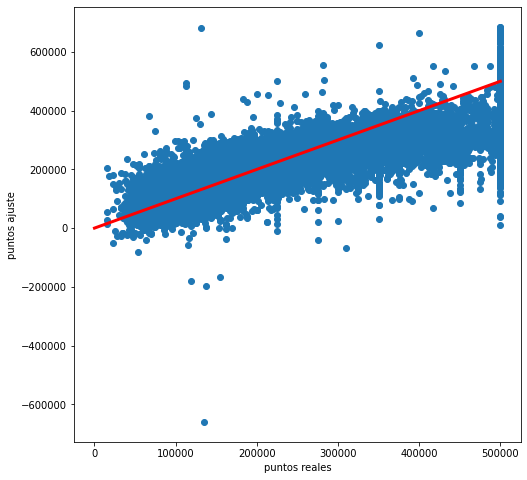

In [31]:
#pintar reales vs predichos
fig = plt.figure(figsize=(8, 8))
y_pred = lm2.predict(housing_prepared)
plt.scatter(y, y_pred)
plt.xlabel("puntos reales")
plt.ylabel("puntos ajuste")
plt.plot([0, max(y)], [0, max(y)], color = 'red', linewidth = 3)
plt.show()

En términos generales el modelo ajusta bien, concentrándose la mayoría de las predic-
ciones alrededor de la bisectriz del primer cuadrante, aunque existen algunas predic-
ciones que arrojan valores negativos, por lo que es necesario trabajar en mejorar el
modelo.

c) Para obtener el valor de la predicción de un barrio donde todas las variables numéricas tienen el valor de la mediana y la variable categórica tiene el valor de la moda,
lo primero es obtener los valores de esa observación y después emplear el método
.predict() de dicha observación. Las medianas se obtienen de aplicar la función
median() al array que contiene a las variables numéricas, mientras que la moda
de la variable categórica se extrae a partir del método .value_conts() de la variable
categórica. Es importante recordar que las medianas es necesario extraerlas de las
variables numéricas una vez han pasado por el pipeline() del tratamiento numérico
para introducirlas en la predicción con sus valores escalados.

In [32]:
# obtener observacion medianas
medianas = np.median(housing_num_tr, axis=0)
print(medianas)
# la moda de

[ 0.53891366 -0.6422871   0.02864572 -0.23321042 -0.24283094 -0.22913175
 -0.23681619 -0.17679508]


In [33]:
print(housing["ocean_proximity"].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


Se observa que el nivel más repetido es el primero, que es el que se incluye en la
interceptación. Por lo tanto, hay que definir a los coeficientes de regresión relativos a
esa variable (β 9 a β 1 2) como 0

In [34]:
# obtener observacion para predecir
array_medianas = np.array(medianas)
x_nueva = np.append(array_medianas, [0, 0, 0, 0])
x2 = x_nueva.reshape(1, -1)
y_nueva = lm2.predict(x2)
print("el valor de y predicho es: ", y_nueva, "dólares.")

el valor de y predicho es:  [210887.88263401] dólares.


# Ejercicio 3. Analizar los resultados obtenidos de los ejercicios 1 y 2:

## a) por separado, comprobar si existe colinealidad entre las variables predictoras.

En el primer paso de este ejercicio se va a realizar es evaluar la posible colinealidad entre
las variables predictoras de los modelos de regresión lineal múltiple de los Ejercicios 1
y 2. Para ello, se emplea la función variance_inflation_factor de la librería statsmodels
sobre un objeto de tipo pandas. En este caso, se tiene que el dataframe del Ejercicio 1
con las variables numéricas después de realizar la imputación es housing_i.

In [35]:
# cargar funcion-------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
# predictores ejercicio 1
housing_i.info()
# crear dataframe para aplicar VIF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [36]:
ej1_VIF = pd.DataFrame()
ej1_VIF["variable"] = housing_i.columns
# aplicar el metodo
ej1_VIF["VIF"] = [variance_inflation_factor(housing_i.values, i)
for i in range(len(housing_i.columns))]
# resultados
print(ej1_VIF)

             variable         VIF
0           longitude  614.390295
1            latitude  548.954416
2  housing_median_age    7.281102
3         total_rooms   29.032423
4      total_bedrooms   70.525566
5          population   16.173089
6          households   73.547059
7       median_income    8.003945


Se observa que la longitud y la latitud presentan unos valores de VIF muy elevados y
podemos estar teniendo un problema de colinealidad.
De modo similar, se procede para obtener el VIF de las variables del modelo del Ejercicio
2, utilizando en este caso un dataframe de tipo pandas a partir de los dataframe
housing_i y que vamos a llamar housing_t.

In [37]:
# cargar funcion-------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
# predictores ejercicio 2
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [38]:
housing_t = pd.merge(housing_i, ocean_df, left_index = True
, right_index=True)
# es necesario quitar una de las variables categoricas-----------
housing_t = housing_t.drop("<1H OCEAN", axis=1)
# Comprobar df creado--------------------------------------------
print(housing_t.info())
# crear dataframe para aplicar VIF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   NEAR BAY            20640 non-null  float64
 9   INLAND              20640 non-null  float64
 10  NEAR OCEAN          20640 non-null  float64
 11  ISLAND              20640 non-null  float64
dtypes: float64(12)
memory usage: 1.9 MB
None


In [39]:
ej2_VIF = pd.DataFrame()
ej2_VIF["variable"] = housing_t.columns
# aplicar el metodo
ej2_VIF["VIF"] = [variance_inflation_factor(housing_t.values, i)
for i in range(len(housing_t.columns))]
# resultados
print(ej2_VIF)

              variable         VIF
0            longitude  942.605262
1             latitude  844.284917
2   housing_median_age    8.116462
3          total_rooms   30.259091
4       total_bedrooms   70.550282
5           population   16.381178
6           households   75.251325
7        median_income    8.822349
8             NEAR BAY    3.881851
9               INLAND    1.003045
10          NEAR OCEAN    1.624071
11              ISLAND    1.798857


Se observa que los valores del VIF para la longitude y la latitude son muy elevados,
además de otras variables como total_bedrooms y households, que también presentan
valores elevados. Lo adecuado, en este caso es acudir a otro tipo de métodos que
puedan adaptarse mejor a la coliniealidad.

## b) compararlos entre sí y compararlos también con la regresión lineal simple del tema anterior.

Una buena manera de comparar modelos con diferente número de variables predictoras
es a través del valor del coeficiente de determinación ajustada. Se tiene, que:
- El modelo de regresión lineal simple obtenía un valor de R 2 = 0.473.
- El modelo con las variables numéricas un coeficiente de determinación ajustado de R^2_adj = 0.636.
- El modelo con todas las variables un coeficiente de determinación ajustado de R^2_adj = 0.645, que esl mayor valor de los 3. Por lo tanto este es el mejor de los tres modelos.

En cualquier caso, como se ha visto que presenta problemas de colinealidad, lo ade-
cuado sería buscar otro tipo de modelo de regresión, como por ejemplo alguno de los
que veremos en el Tema 6.